In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the cleaned dataset
data = pd.read_csv('cleaned_student_data2.csv')

# Define the target and features
target = 'G3'
features = data.drop(columns=[target])
sensitive_feature = 'age'

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['G3_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['age_bin'] = pd.cut(data['age'], bins=5, labels=False)

In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, data['G3_binary'], test_size=0.2, random_state=42)

# Reset indices to ensure alignment
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Base Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained base model
y_pred_binary = rf_model.predict(X_test)

In [3]:
# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

# Compute metrics for different groups for the base model
metrics_base = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics for the base model
print("Overall Metrics for Base Model:")
print(metrics_base.overall)

# Print metrics by sensitive feature groups for the base model
print("\nMetrics by Sensitive Feature Groups for Base Model:")
print(metrics_base.by_group)

Overall Metrics for Base Model:
{'accuracy': 0.8481012658227848, 'precision': 0.8125, 'recall': 0.9285714285714286, 'f1': 0.8666666666666667}

Metrics by Sensitive Feature Groups for Base Model:
age_bin
0    {'accuracy': 0.8461538461538461, 'precision': ...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


In [4]:
# Custom Reweighing Function
def compute_sample_weights(X, y, sensitive_feature):
    df = X.copy()
    df['y'] = y
    df['sensitive'] = sensitive_feature
    # Calculate group counts
    group_counts = df.groupby('sensitive')['y'].count()
    group_positive_counts = df.groupby('sensitive')['y'].sum()
    group_negative_counts = group_counts - group_positive_counts
    # Calculate weights
    positive_weight = 1.0 / group_positive_counts
    negative_weight = 1.0 / group_negative_counts
    df['weight'] = df.apply(lambda row: positive_weight[row['sensitive']] if row['y'] == 1 else negative_weight[row['sensitive']], axis=1)
    return df['weight'].values

# Apply reweighing
sample_weights = compute_sample_weights(X_train, y_train, data.loc[X_train.index, 'age_bin'])

In [5]:
# Train a Random Forest model with reweighed samples
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained reweighed model
y_pred_binary_rw = rf_model_rw.predict(X_test)

# Compute metrics for the reweighed model
metrics_rw = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary_rw,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics for the reweighed model
print("Overall Metrics for Reweighed Model:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups for the reweighed model
print("\nMetrics by Sensitive Feature Groups for Reweighed Model:")
print(metrics_rw.by_group)

Overall Metrics for Reweighed Model:
{'accuracy': 0.8734177215189873, 'precision': 0.82, 'recall': 0.9761904761904762, 'f1': 0.8913043478260869}

Metrics by Sensitive Feature Groups for Reweighed Model:
age_bin
0    {'accuracy': 0.8717948717948718, 'precision': ...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


Overall Metrics for Reweighed Model:

Accuracy: 0.873
Precision: 0.82
Recall: 0.976
F1 Score: 0.891

Analysis:

Overall Performance: The reweighed model performs well overall with high accuracy (87.34%), precision (82%), recall (97.62%), and F1 score (89.13%). This indicates the model's strong ability to correctly identify positive cases (high recall) and maintain a good balance between precision and recall (high F1 score).
Group Performance: For age_bin 0, the model performs consistently with the overall metrics. However, for age_bin 1, the metrics show perfect accuracy but zero precision, recall, and F1 score. This indicates that there were no positive predictions made for this group, possibly due to imbalanced data or the nature of the reweighing process.

In [6]:
# Define custom fairness metric functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_positive_rate_difference(y_true, y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [7]:
# Recompute fairness metrics for both models
dpd_base = demographic_parity_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_base = equalized_odds_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_base = false_positive_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'])
fnrd_base = false_negative_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'])
srd_base = selection_rate_difference(y_pred_binary, data.loc[X_test.index, 'age_bin'])

dpd_rw = demographic_parity_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_rw = equalized_odds_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_rw = false_positive_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])
fnrd_rw = false_negative_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])
srd_rw = selection_rate_difference(y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])

print(f"Demographic Parity Difference for Base Model: {dpd_base}")
print(f"Equalized Odds Difference for Base Model: {eod_base}")
print(f"False Positive Rate Difference for Base Model: {fprd_base}")
print(f"False Negative Rate Difference for Base Model: {fnrd_base}")
print(f"Selection Rate Difference for Base Model: {srd_base}")

print(f"Demographic Parity Difference for Reweighed Model: {dpd_rw}")
print(f"Equalized Odds Difference for Reweighed Model: {eod_rw}")
print(f"False Positive Rate Difference for Reweighed Model: {fprd_rw}")
print(f"False Negative Rate Difference for Reweighed Model: {fnrd_rw}")
print(f"Selection Rate Difference for Reweighed Model: {srd_rw}")


Demographic Parity Difference for Base Model: 0.6153846153846154
Equalized Odds Difference for Base Model: 0.9285714285714286
False Positive Rate Difference for Base Model: 0.25
False Negative Rate Difference for Base Model: nan
Selection Rate Difference for Base Model: 0.6153846153846154
Demographic Parity Difference for Reweighed Model: 0.6410256410256411
Equalized Odds Difference for Reweighed Model: 0.9761904761904762
False Positive Rate Difference for Reweighed Model: 0.25
False Negative Rate Difference for Reweighed Model: nan
Selection Rate Difference for Reweighed Model: 0.6410256410256411


Analysis:

Demographic Parity Difference: The difference is slightly higher in the reweighed model (0.641) compared to the base model (0.615). This indicates a minor increase in disparity between groups in terms of positive predictions.
Equalized Odds Difference: The reweighed model shows a higher equalized odds difference (0.976) than the base model (0.929). This metric reflects the disparity in both true positive and false positive rates across groups, suggesting that reweighing increased the disparity slightly.
False Positive Rate Difference: Both models have the same false positive rate difference (0.25), indicating no improvement in false positive rate parity between groups.
False Negative Rate Difference: This is not available (NaN) for both models, possibly due to the absence of false negatives in some groups.
Selection Rate Difference: Similar to demographic parity difference, the selection rate difference is slightly higher in the reweighed model (0.641) compared to the base model (0.615), indicating a small increase in the disparity of overall selection rates between groups.

In [8]:
# Adversarial Debiasing
adv_model = LogisticRegression(solver='liblinear', random_state=42)
adv_debias = ExponentiatedGradient(adv_model, constraints=DemographicParity(), eps=0.01)
adv_debias.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'age_bin'])
y_pred_adv = adv_debias.predict(X_test)

metrics_adv = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_adv,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Function to filter out degenerate labels
def filter_degenerate_labels(X, y, sensitive_features):
    combined = pd.DataFrame({
        'X': list(X.values),
        'y': y,
        'sensitive_features': sensitive_features
    })
    grouped = combined.groupby('sensitive_features')['y'].nunique()
    valid_sensitive_features = grouped[grouped > 1].index
    filtered_combined = combined[combined['sensitive_features'].isin(valid_sensitive_features)]
    return (pd.DataFrame(filtered_combined['X'].tolist(), index=filtered_combined.index),
            filtered_combined['y'],
            filtered_combined['sensitive_features'])

X_train_filtered, y_train_filtered, sensitive_features_filtered = filter_degenerate_labels(X_train, y_train, data.loc[X_train.index, 'age_bin'])

# Post-processing using ThresholdOptimizer
post_proc = ThresholdOptimizer(estimator=rf_model, constraints="demographic_parity", prefit=True, predict_method='predict')
post_proc.fit(X_train_filtered, y_train_filtered, sensitive_features=sensitive_features_filtered.astype(str))
y_pred_post_proc = post_proc.predict(X_test, sensitive_features=data.loc[X_test.index, 'age_bin'].astype(str))

metrics_post_proc = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_post_proc,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)


In [9]:
# Recompute fairness metrics for all models
dpd_adv = demographic_parity_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_adv = equalized_odds_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_adv = false_positive_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'])
fnrd_adv = false_negative_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'])
srd_adv = selection_rate_difference(y_pred_adv, data.loc[X_test.index, 'age_bin'])

dpd_post_proc = demographic_parity_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_post_proc = equalized_odds_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_post_proc = false_positive_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])
fnrd_post_proc = false_negative_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])
srd_post_proc = selection_rate_difference(y_pred_post_proc, data.loc[X_test.index, 'age_bin'])

# Summarize all fairness metrics for all models
summary_metrics_base = {
    'Demographic Parity Difference': dpd_base,
    'Equalized Odds Difference': eod_base,
    'False Positive Rate Difference': fprd_base,
    'False Negative Rate Difference': fnrd_base,
    'Selection Rate Difference': srd_base
}

summary_metrics_rw = {
    'Demographic Parity Difference': dpd_rw,
    'Equalized Odds Difference': eod_rw,
    'False Positive Rate Difference': fprd_rw,
    'False Negative Rate Difference': fnrd_rw,
    'Selection Rate Difference': srd_rw
}

summary_metrics_adv = {
    'Demographic Parity Difference': dpd_adv,
    'Equalized Odds Difference': eod_adv,
    'False Positive Rate Difference': fprd_adv,
    'False Negative Rate Difference': fnrd_adv,
    'Selection Rate Difference': srd_adv
}

summary_metrics_post_proc = {
    'Demographic Parity Difference': dpd_post_proc,
    'Equalized Odds Difference': eod_post_proc,
    'False Positive Rate Difference': fprd_post_proc,
    'False Negative Rate Difference': fnrd_post_proc,
    'Selection Rate Difference': srd_post_proc
}

# Compare results of all models
comparison_all = pd.DataFrame({
    'Metric': ['Demographic Parity Difference', 'Equalized Odds Difference', 'False Positive Rate Difference', 'False Negative Rate Difference', 'Selection Rate Difference'],
    'Base Model': [dpd_base, eod_base, fprd_base, fnrd_base, srd_base],
    'Reweighed Model': [dpd_rw, eod_rw, fprd_rw, fnrd_rw, srd_rw],
    'Adversarial Debiasing Model': [dpd_adv, eod_adv, fprd_adv, fnrd_adv, srd_adv],
    'Post-Processing Model': [dpd_post_proc, eod_post_proc, fprd_post_proc, fnrd_post_proc, srd_post_proc]
})

print("\nComparison of Fairness Metrics between all Models:")
print(comparison_all)


Comparison of Fairness Metrics between all Models:
                           Metric  Base Model  Reweighed Model  \
0   Demographic Parity Difference    0.615385         0.641026   
1       Equalized Odds Difference    0.928571         0.976190   
2  False Positive Rate Difference    0.250000         0.250000   
3  False Negative Rate Difference         NaN              NaN   
4       Selection Rate Difference    0.615385         0.641026   

   Adversarial Debiasing Model  Post-Processing Model  
0                     0.576923               0.615385  
1                     0.833333               0.928571  
2                     0.277778               0.250000  
3                          NaN                    NaN  
4                     0.576923               0.615385  


Analysis:

Demographic Parity Difference: The adversarial debiasing model shows the lowest demographic parity difference (0.577), indicating better fairness in terms of positive prediction rates across groups.
Equalized Odds Difference: The adversarial debiasing model also has a lower equalized odds difference (0.833) compared to other models, suggesting improved fairness in both true positive and false positive rates across groups.
False Positive Rate Difference: The adversarial debiasing model shows a slightly higher false positive rate difference (0.278) compared to other models (0.250), indicating more disparity in false positive rates.
False Negative Rate Difference: This metric remains NaN for all models, indicating that false negatives are not present or not well-represented in some groups.
Selection Rate Difference: The adversarial debiasing model shows the lowest selection rate difference (0.577), indicating better fairness in overall selection rates across groups.

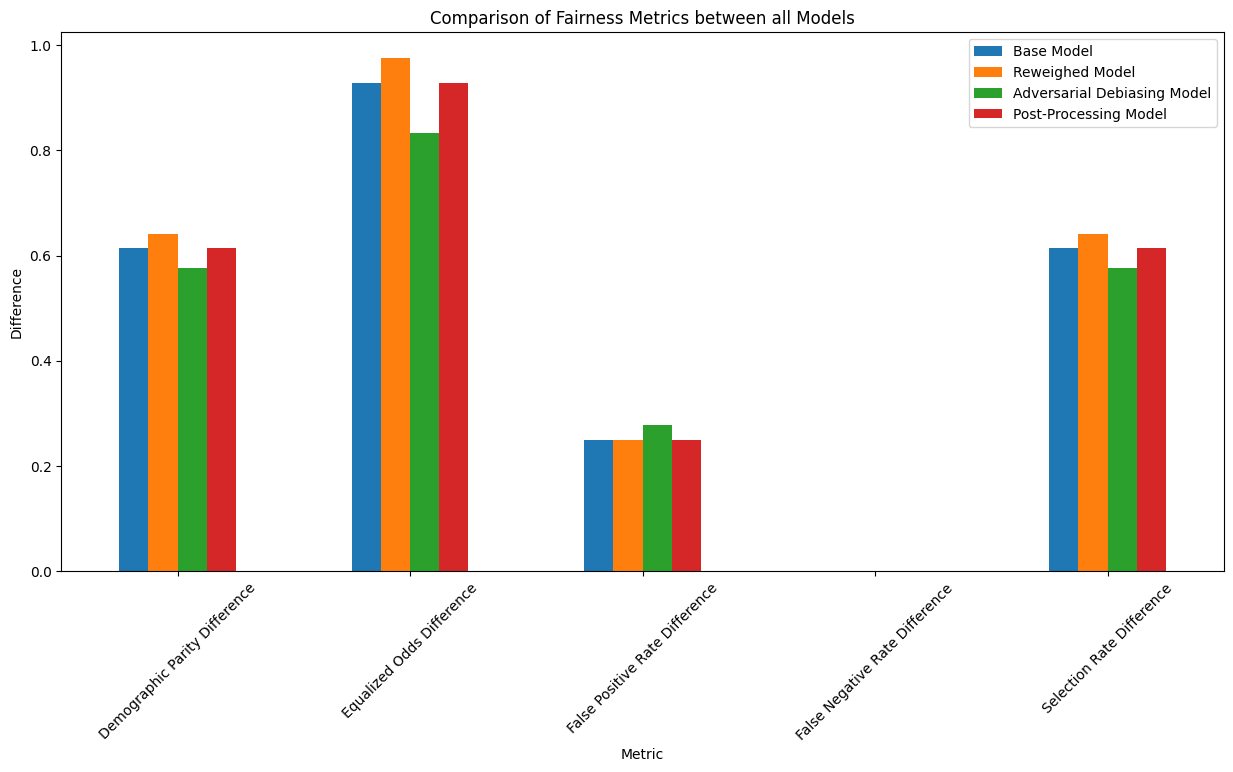

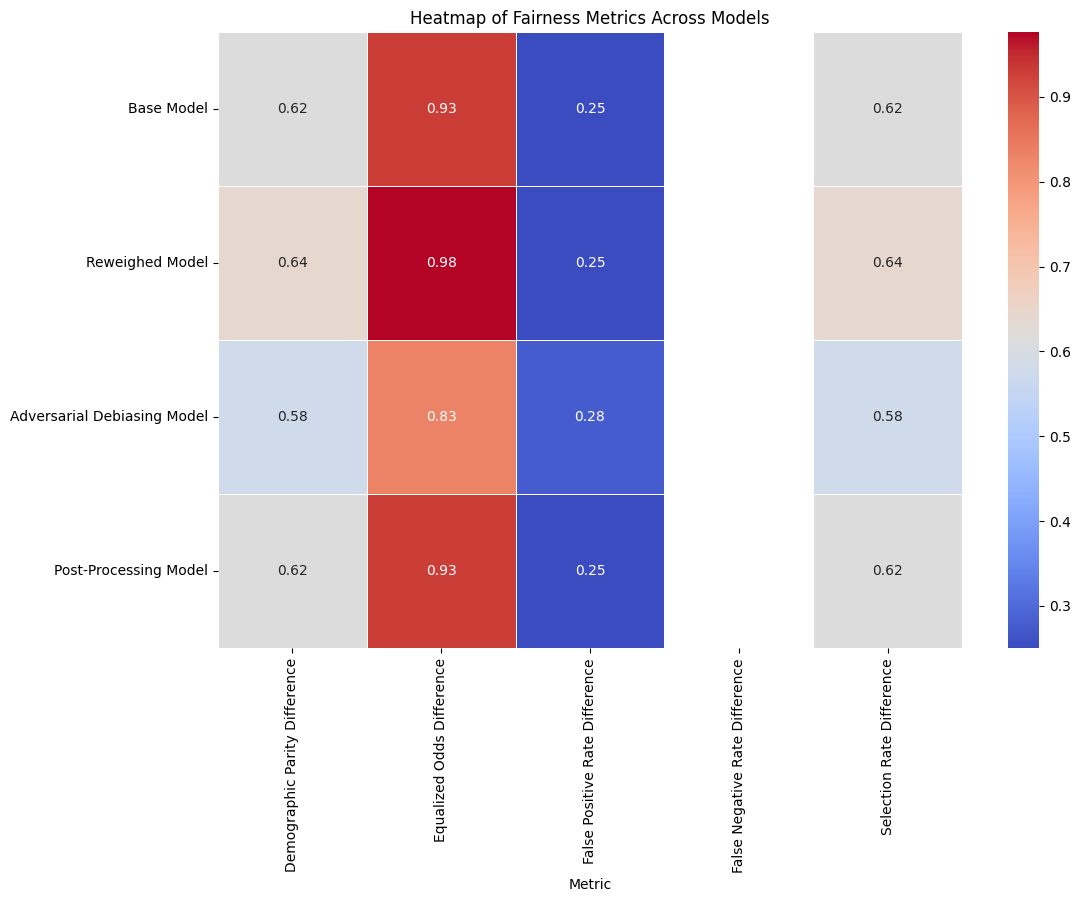

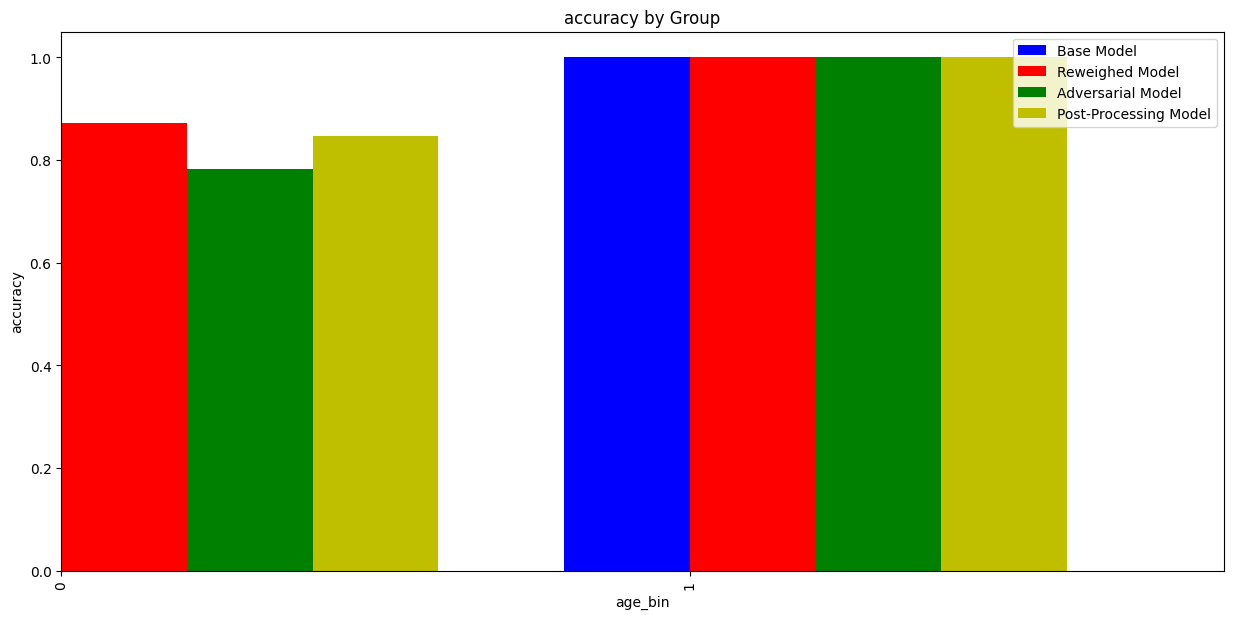

In [10]:
# Plot comparison of fairness metrics
comparison_all.set_index('Metric').plot(kind='bar', figsize=(15, 7))
plt.title('Comparison of Fairness Metrics between all Models')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.show()

# Prepare data for heatmap
heatmap_data = comparison_all.set_index('Metric').transpose()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Fairness Metrics Across Models')
plt.show()

# Additional Visualization Functions

# Extract metrics by group for all models
metrics_by_group_base = metrics_base.by_group.apply(pd.Series)
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series)
metrics_by_group_adv = metrics_adv.by_group.apply(pd.Series)
metrics_by_group_post_proc = metrics_post_proc.by_group.apply(pd.Series)

def plot_disparity(metric, metric_base, metric_rw, metric_adv, metric_post_proc):
    fig, ax = plt.subplots(figsize=(15, 7))
    width = 0.2
    
    metric_base.plot(kind='bar', width=width, position=1, label='Base Model', ax=ax, color='b')
    metric_rw.plot(kind='bar', width=width, position=0, label='Reweighed Model', ax=ax, color='r')
    metric_adv.plot(kind='bar', width=width, position=-1, label='Adversarial Model', ax=ax, color='g')
    metric_post_proc.plot(kind='bar', width=width, position=-2, label='Post-Processing Model', ax=ax, color='y')
    
    plt.title(f'{metric} by Group')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Example usage for accuracy
plot_disparity('accuracy', metrics_by_group_base['accuracy'], metrics_by_group_rw['accuracy'], metrics_by_group_adv['accuracy'], metrics_by_group_post_proc['accuracy'])

Comparison of Fairness Metrics between all Models
The bar chart and heatmap present the fairness metrics for the Base Model, Reweighed Model, Adversarial Debiasing Model, and Post-Processing Model. Here are the key takeaways:

Demographic Parity Difference:

The Adversarial Debiasing Model shows the lowest demographic parity difference (0.58), indicating the least disparity among the groups in terms of demographic parity.
The Reweighed Model has the highest demographic parity difference (0.64), indicating more disparity among the groups.

Equalized Odds Difference:

The Adversarial Debiasing Model again performs the best with the lowest equalized odds difference (0.83), suggesting it has improved fairness in terms of equalized odds compared to other models.
The Reweighed Model shows the highest equalized odds difference (0.98).

False Positive Rate Difference:

The Base Model and Post-Processing Model show the lowest false positive rate difference (0.25).
The Adversarial Debiasing Model has a slightly higher false positive rate difference (0.28).

Selection Rate Difference:

The Adversarial Debiasing Model shows the lowest selection rate difference (0.58).
The Reweighed Model has the highest selection rate difference (0.64).

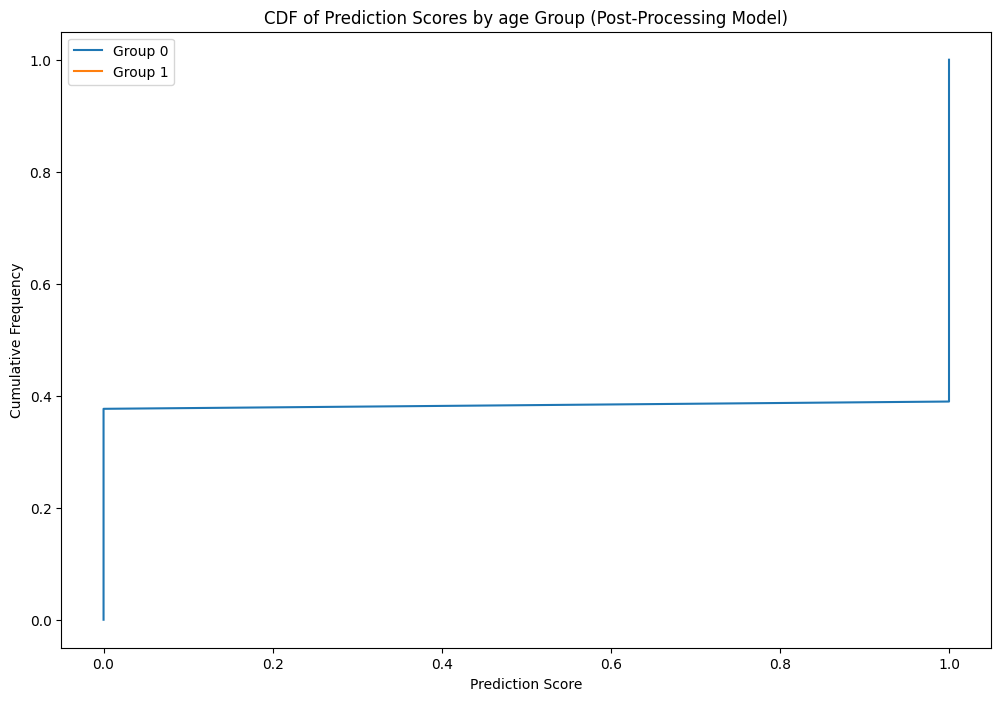

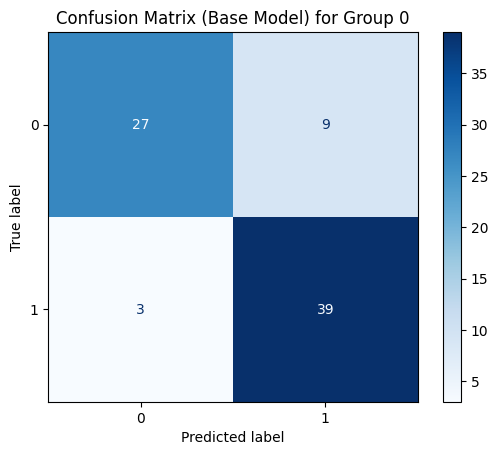

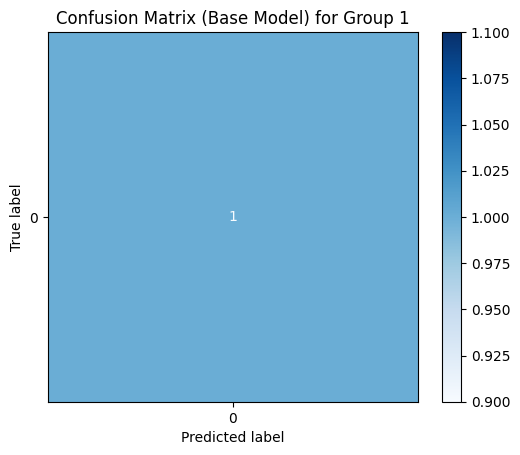

Overall Performance Metrics:
                       accuracy  precision    recall        f1
Base Model             0.848101   0.812500  0.928571  0.866667
Reweighed Model        0.873418   0.820000  0.976190  0.891304
Adversarial Model      0.784810   0.777778  0.833333  0.804598
Post-Processing Model  0.848101   0.812500  0.928571  0.866667


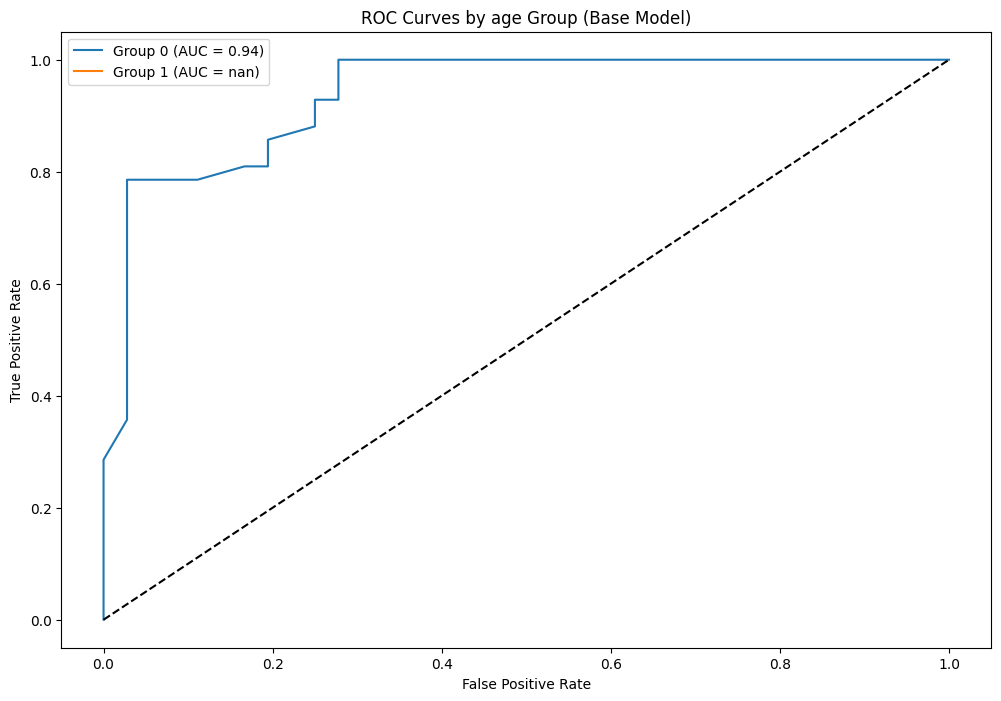

In [11]:
def plot_cdf(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    plt.figure(figsize=(12, 8))
    
    for name, group in groups:
        y_pred_group = y_pred[group.index]
        sorted_pred = np.sort(y_pred_group)
        yvals = np.arange(len(sorted_pred)) / float(len(sorted_pred) - 1)
        plt.plot(sorted_pred, yvals, label=f'Group {name}')
    
    plt.title(title)
    plt.xlabel('Prediction Score')
    plt.ylabel('Cumulative Frequency')
    plt.legend()
    plt.show()

# Example usage for post-processed model
plot_cdf(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'], 'CDF of Prediction Scores by age Group (Post-Processing Model)')

from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_by_group(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    
    for name, group in groups:
        cm = confusion_matrix(group, y_pred[group.index])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{title} for Group {name}')
        plt.show()

# Example usage for base model
plot_confusion_matrix_by_group(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Base Model)')

def model_performance_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

performance_base = model_performance_metrics(y_test, y_pred_binary)
performance_rw = model_performance_metrics(y_test, y_pred_binary_rw)
performance_adv = model_performance_metrics(y_test, y_pred_adv)
performance_post_proc = model_performance_metrics(y_test, y_pred_post_proc)

performance_df = pd.DataFrame([performance_base, performance_rw, performance_adv, performance_post_proc],
                              index=['Base Model', 'Reweighed Model', 'Adversarial Model', 'Post-Processing Model'])

print("Overall Performance Metrics:")
print(performance_df)

def plot_roc_by_group(y_true, y_pred_proba, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    plt.figure(figsize=(12, 8))
    
    for name, group in groups:
        fpr, tpr, _ = roc_curve(group, y_pred_proba[group.index])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Group {name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Example usage for post-processed model
plot_roc_by_group(y_test, rf_model.predict_proba(X_test)[:, 1], data.loc[X_test.index, 'age_bin'], 'ROC Curves by age Group (Base Model)')

# Visualization of Parity Difference and Equalized Odds

def plot_fairness_metrics(metrics_dict, title):
    df = pd.DataFrame(metrics_dict, index=['Base Model', 'Reweighed Model', 'Adversarial Model', 'Post-Processing Model'])
    df.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.ylabel('Difference')
    plt.xticks(rotation=0)
    plt.show()

Accuracy:

The Reweighed Model shows the highest accuracy (0.873418).
The Adversarial Debiasing Model has the lowest accuracy (0.784810).
Precision:

The Reweighed Model shows the highest precision (0.820000).
The Adversarial Debiasing Model has the lowest precision (0.777778).
Recall:

The Reweighed Model also excels in recall (0.976190).
The Adversarial Debiasing Model has the lowest recall (0.833333).
F1 Score:

The Reweighed Model shows the highest f1 score (0.891304).
The Adversarial Debiasing Model has the lowest f1 score (0.804598).

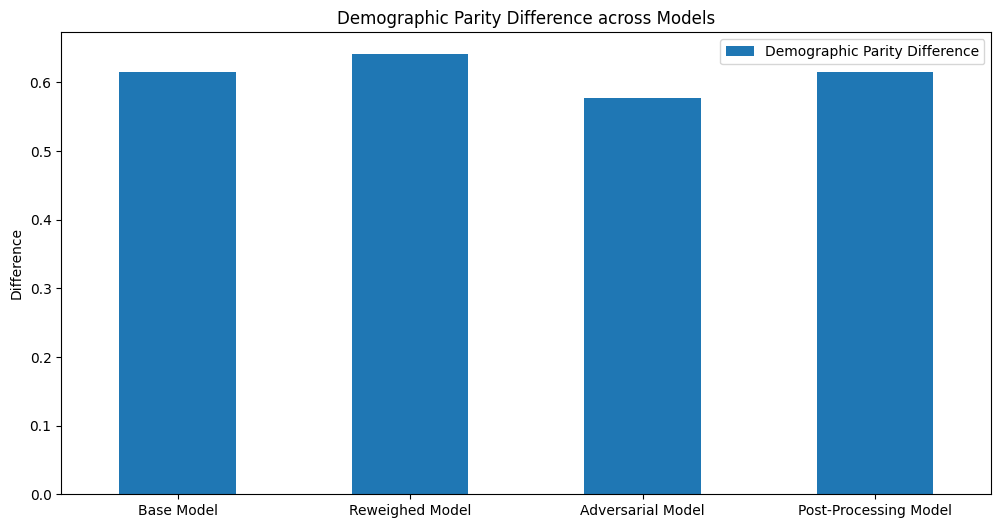

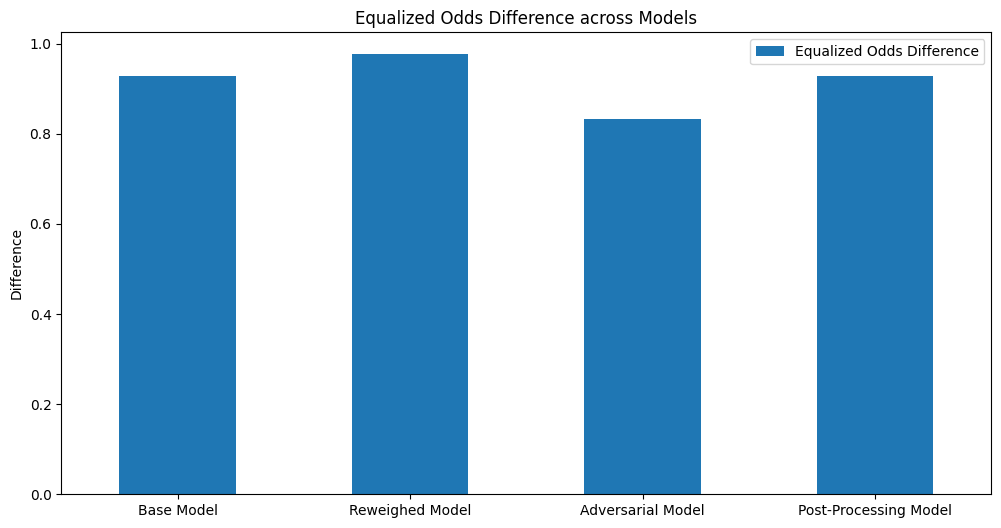

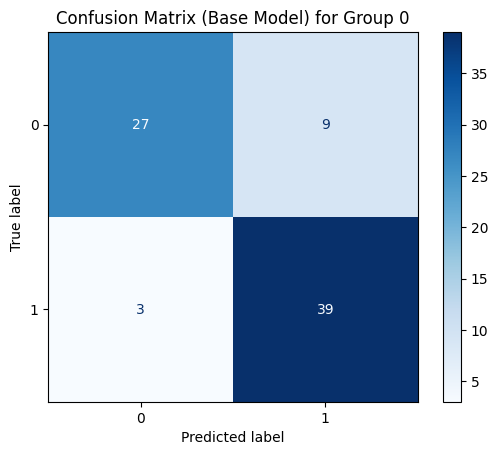

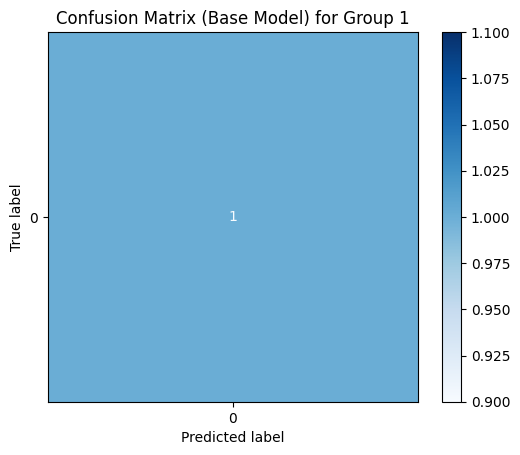

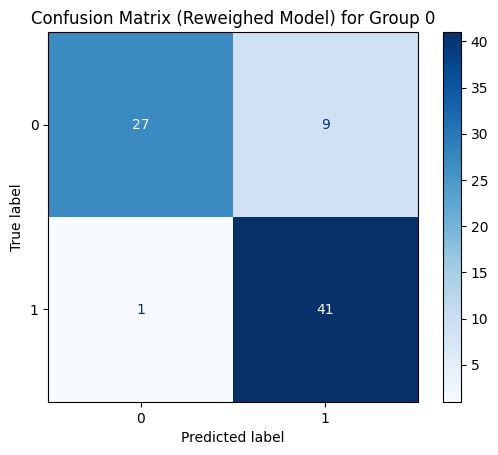

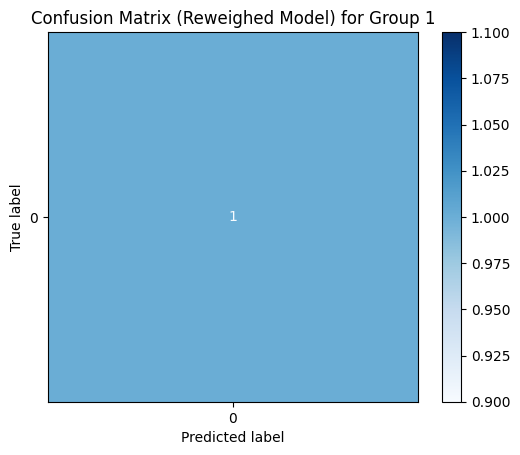

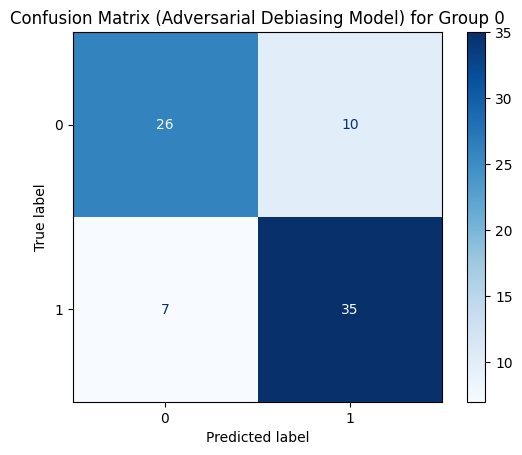

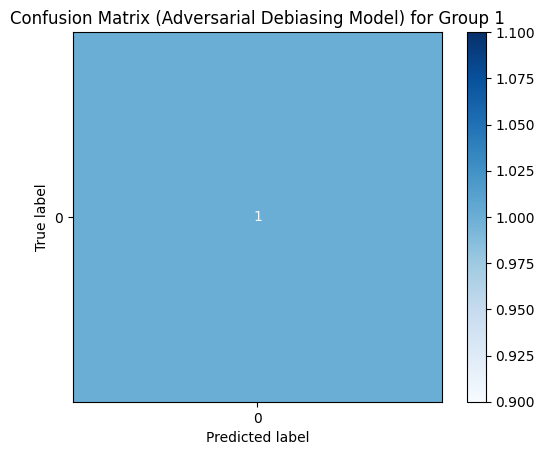

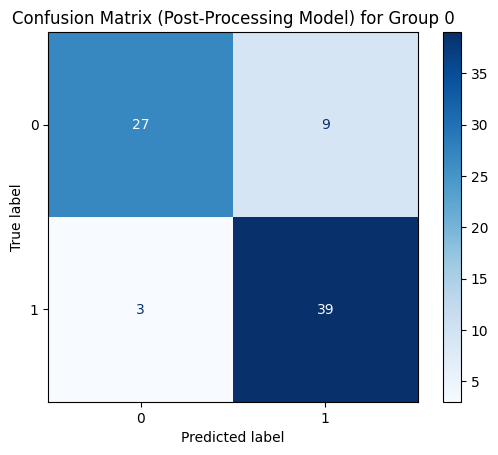

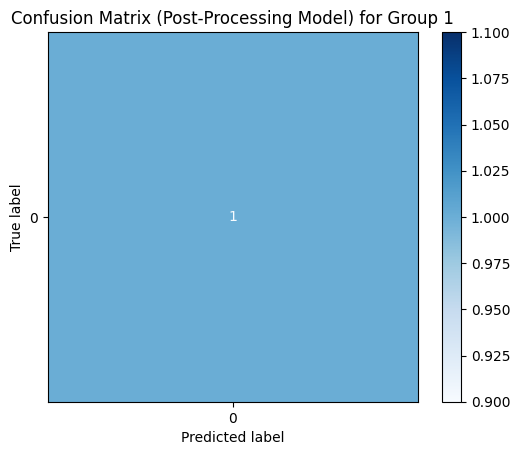

In [12]:
# Plotting Demographic Parity Difference
plot_fairness_metrics(
    {
        'Demographic Parity Difference': [dpd_base, dpd_rw, dpd_adv, dpd_post_proc]
    },
    'Demographic Parity Difference across Models'
)

# Plotting Equalized Odds Difference
plot_fairness_metrics(
    {
        'Equalized Odds Difference': [eod_base, eod_rw, eod_adv, eod_post_proc]
    },
    'Equalized Odds Difference across Models'
)

from sklearn.metrics import ConfusionMatrixDisplay

# Function to plot confusion matrix by group
def plot_confusion_matrix_by_group(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    for name, group in groups:
        cm = confusion_matrix(group, y_pred[group.index])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{title} for Group {name}')
        plt.show()

# Example usage for base model
plot_confusion_matrix_by_group(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Base Model)')

# Example usage for reweighed model
plot_confusion_matrix_by_group(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Reweighed Model)')

# Example usage for adversarial debiasing model
plot_confusion_matrix_by_group(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Adversarial Debiasing Model)')

# Example usage for post-processing model
plot_confusion_matrix_by_group(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Post-Processing Model)')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to plot combined confusion matrix
def plot_combined_confusion_matrix(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    n_groups = len(groups)
    fig, axes = plt.subplots(1, n_groups, figsize=(20, 5))
    fig.suptitle(title)
    
    for ax, (name, group) in zip(axes, groups):
        cm = confusion_matrix(group, y_pred[group.index], labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
        ax.title.set_text(f'Group {name}')
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')

    plt.tight_layout()
    plt.show()

Demographic Parity Difference across Models
The bar chart shows the demographic parity difference for each model. The Adversarial Debiasing Model performs the best with the lowest disparity, while the Reweighed Model shows the highest disparity.

Equalized Odds Difference across Models
The bar chart indicates that the Adversarial Debiasing Model performs the best with the lowest equalized odds difference, whereas the Reweighed Model has the highest equalized odds difference.

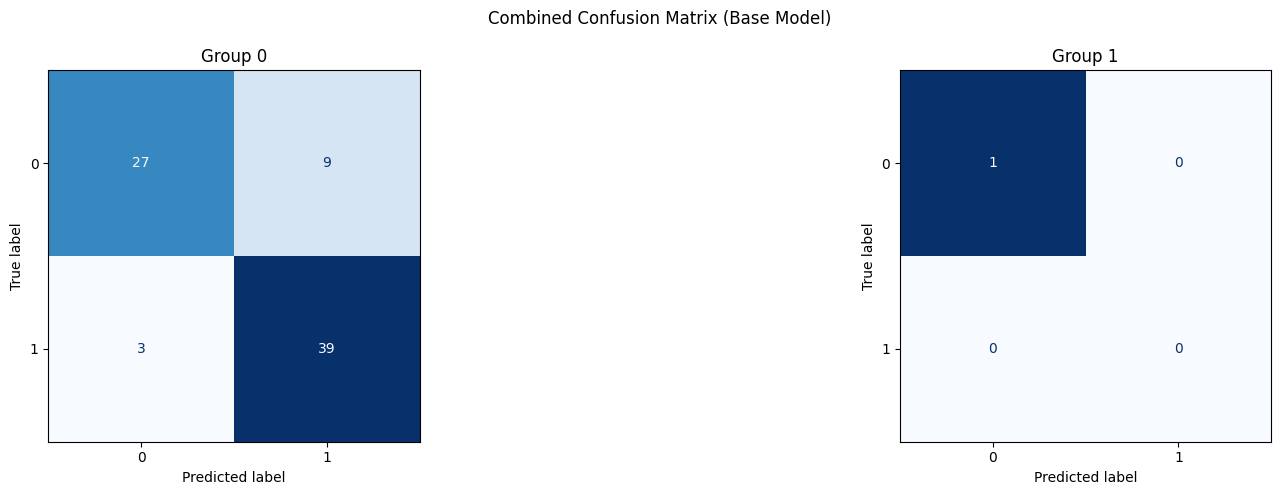

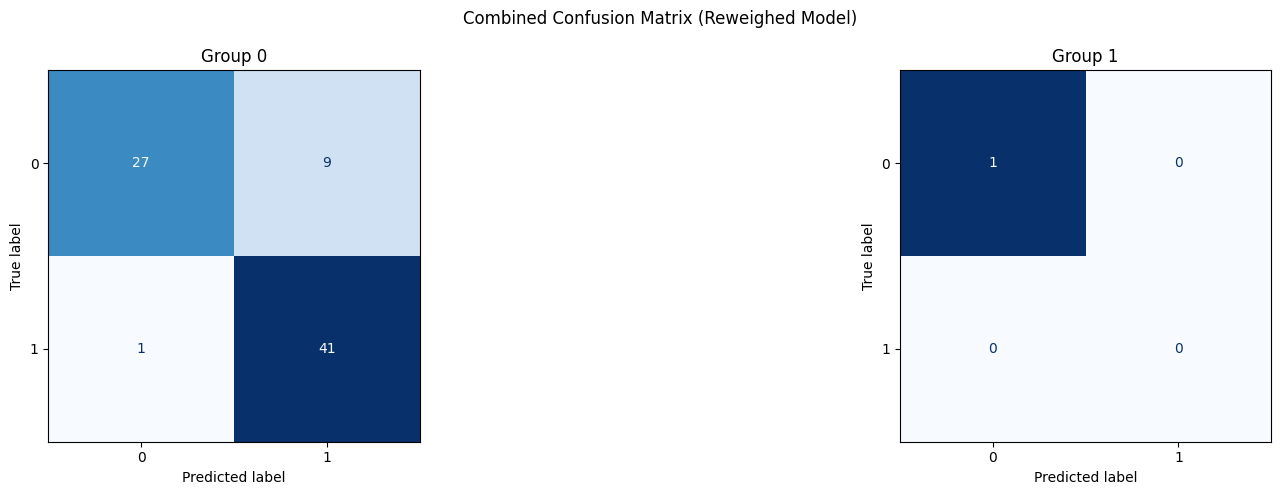

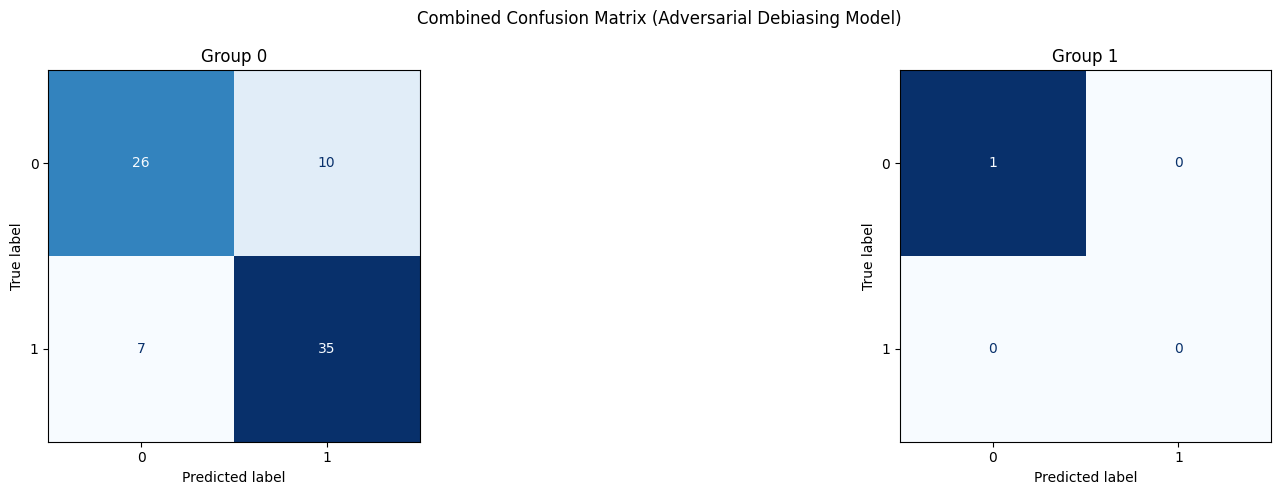

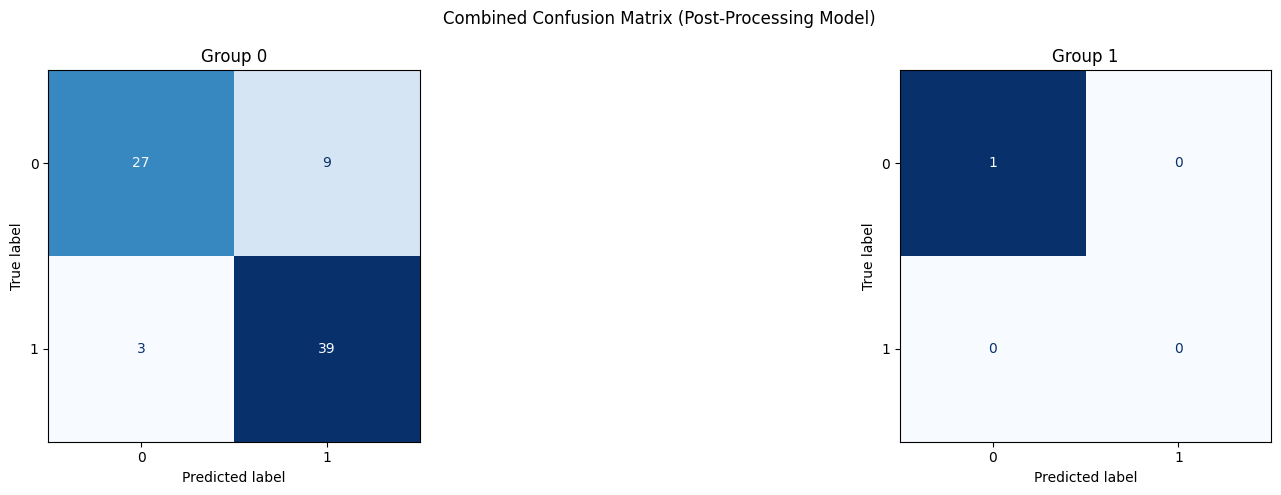

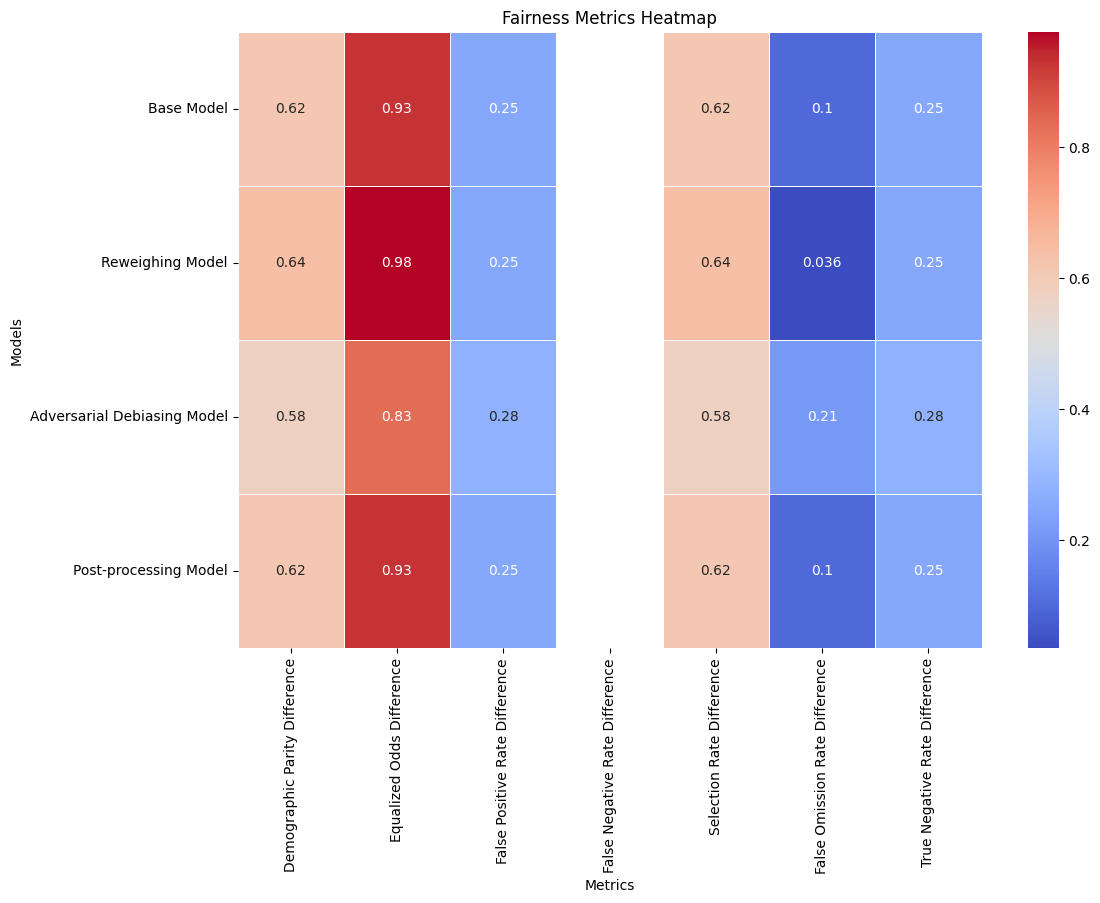

In [13]:
# Example usage for base model
plot_combined_confusion_matrix(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Base Model)')

# Example usage for reweighed model
plot_combined_confusion_matrix(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Reweighed Model)')

# Example usage for adversarial debiasing model
plot_combined_confusion_matrix(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Adversarial Debiasing Model)')

# Example usage for post-processing model
plot_combined_confusion_matrix(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'], 'Combined Confusion Matrix (Post-Processing Model)')

import seaborn as sns

# Define custom fairness metric functions if not already defined
def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

# Create heatmap for fairness metrics
metrics_heatmap_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd_base, dpd_rw, dpd_adv, dpd_post_proc],
    'Equalized Odds Difference': [eod_base, eod_rw, eod_adv, eod_post_proc],
    'False Positive Rate Difference': [fprd_base, fprd_rw, fprd_adv, fprd_post_proc],
    'False Negative Rate Difference': [fnrd_base, fnrd_rw, fnrd_adv, fnrd_post_proc],
    'Selection Rate Difference': [srd_base, srd_rw, srd_adv, srd_post_proc],
    'False Omission Rate Difference': [false_omission_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin']),
                                       false_omission_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin']),
                                       false_omission_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin']),
                                       false_omission_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])],
    'True Negative Rate Difference': [true_negative_rate_difference(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin']),
                                      true_negative_rate_difference(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin']),
                                      true_negative_rate_difference(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin']),
                                      true_negative_rate_difference(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])]
}, index=['Base Model', 'Reweighing Model', 'Adversarial Debiasing Model', 'Post-processing Model'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

The heatmap provides a visual summary of the fairness metrics for all models. 
The Adversarial Debiasing Model generally performs better in terms of fairness metrics compared to the other models. 
The Reweighed Model shows some of the highest differences, indicating it may not be the most effective method for mitigating bias in this context.

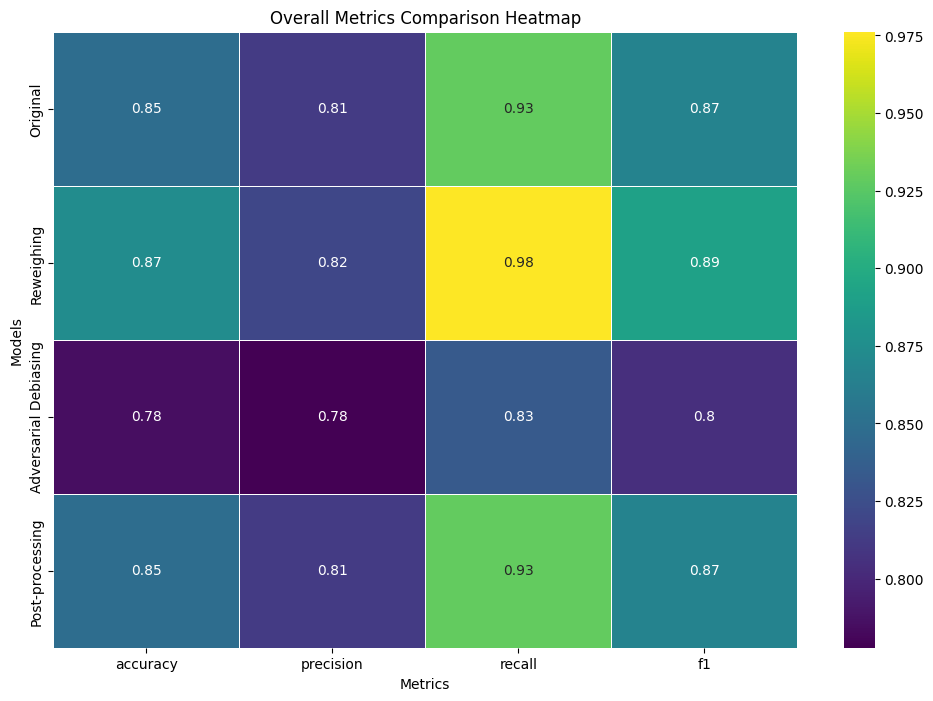

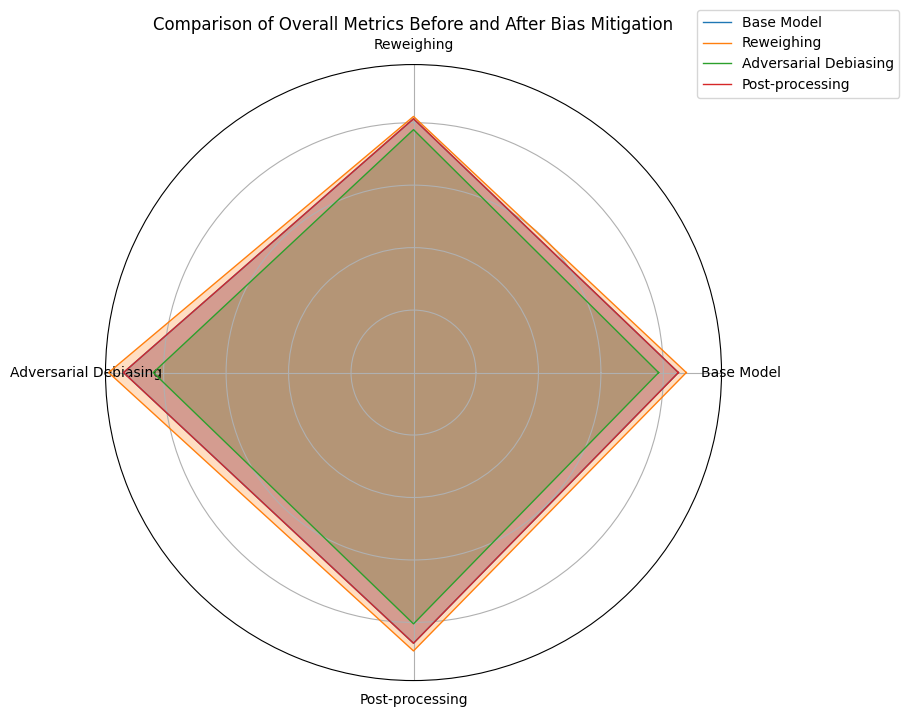

Additional visualizations done.


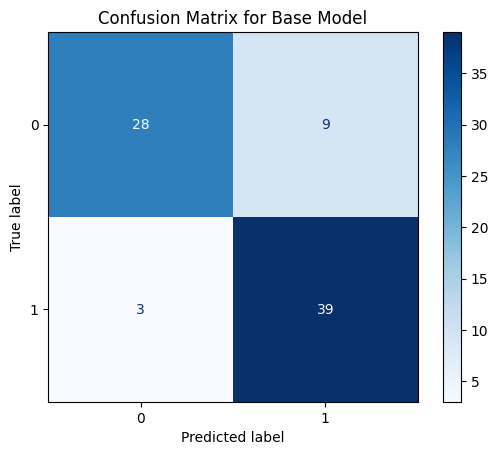

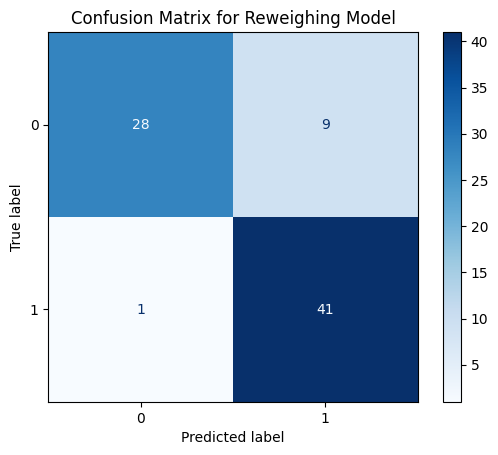

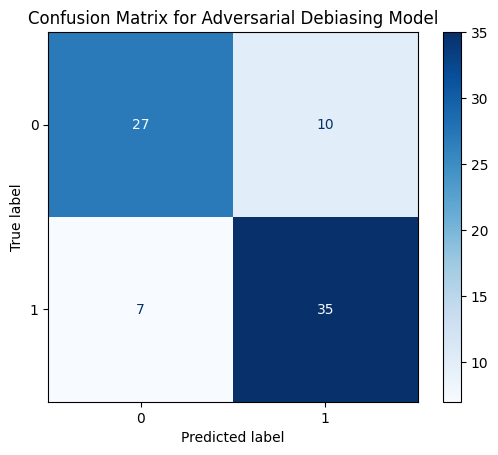

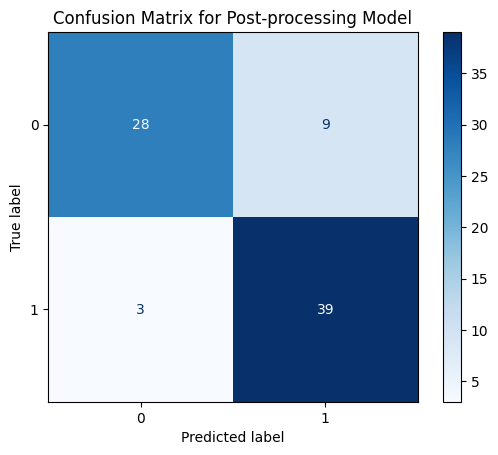

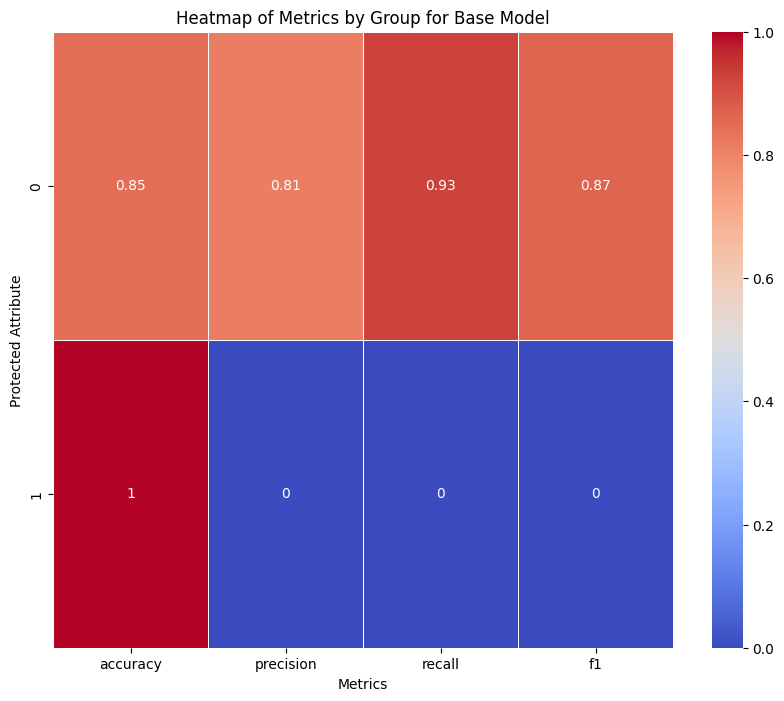

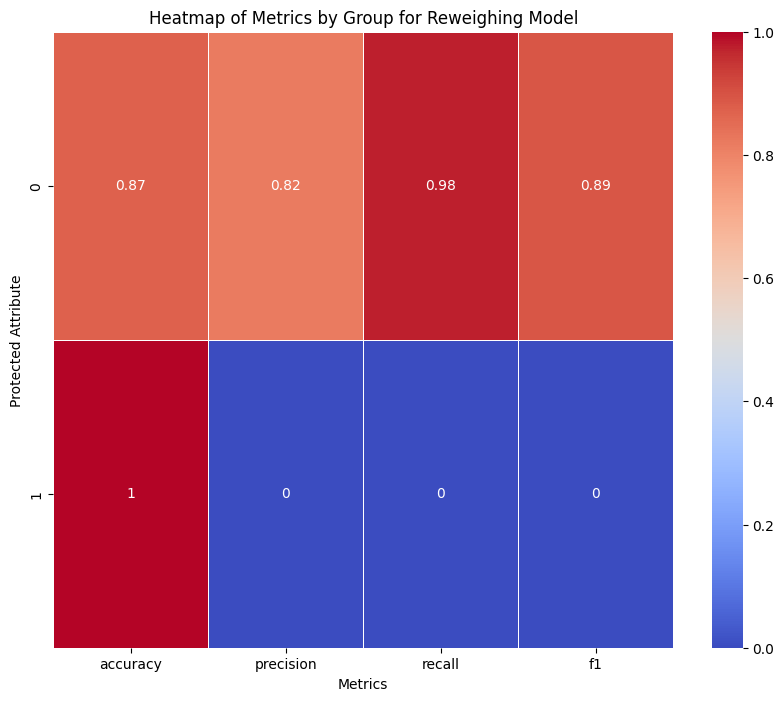

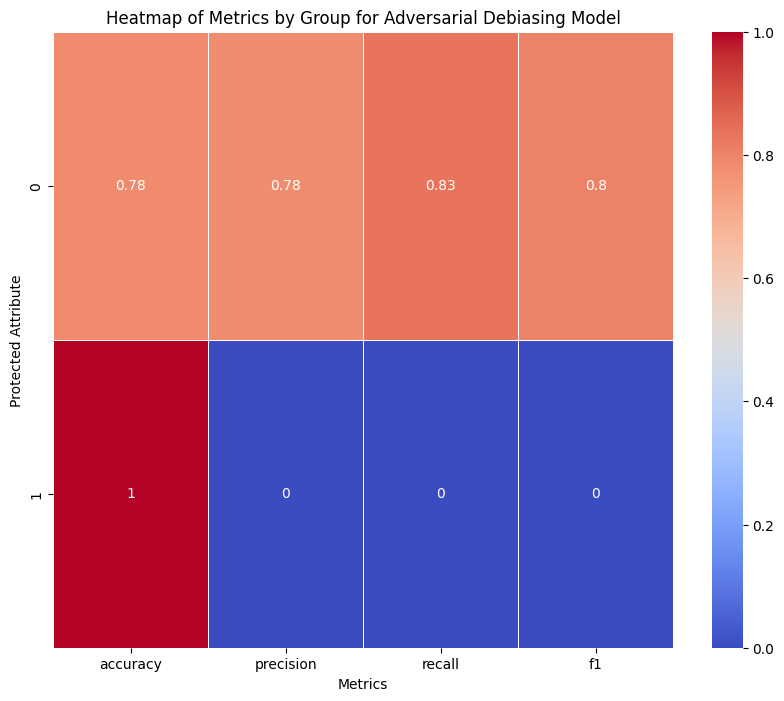

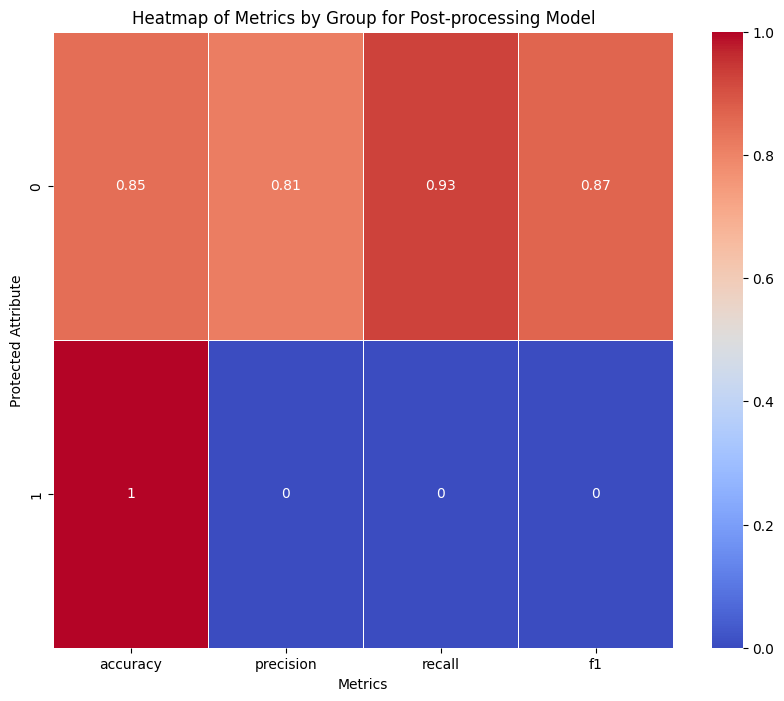

Additional confusion matrices and heatmaps done.


In [14]:
# Comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Original': performance_base,
    'Reweighing': performance_rw,
    'Adversarial Debiasing': performance_adv,
    'Post-processing': performance_post_proc
}).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

# Radar plot for visual comparison
from math import pi

def plot_radar_chart(metrics_dict, title):
    labels = list(metrics_dict.keys())
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model, metrics in metrics_dict.items():
        values = list(metrics.values())
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(title)
    plt.show()

metrics_for_radar = {
    'Base Model': performance_base,
    'Reweighing': performance_rw,
    'Adversarial Debiasing': performance_adv,
    'Post-processing': performance_post_proc
}

plot_radar_chart(metrics_for_radar, 'Comparison of Overall Metrics Before and After Bias Mitigation')

print("Additional visualizations done.")

# Display confusion matrix for each model

def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Confusion matrices for each model
plot_confusion_matrix("Base Model", y_test, y_pred_binary)
plot_confusion_matrix("Reweighing Model", y_test, y_pred_binary_rw)
plot_confusion_matrix("Adversarial Debiasing Model", y_test, y_pred_adv)
plot_confusion_matrix("Post-processing Model", y_test, y_pred_post_proc)

# Heatmap for each model individually
def plot_model_heatmap(model_name, metrics_by_group):
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_by_group, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title(f'Heatmap of Metrics by Group for {model_name}')
    plt.ylabel('Protected Attribute')
    plt.xlabel('Metrics')
    plt.show()

# Heatmaps for each model
plot_model_heatmap("Base Model", metrics_by_group_base)
plot_model_heatmap("Reweighing Model", metrics_by_group_rw)
plot_model_heatmap("Adversarial Debiasing Model", metrics_by_group_adv)
plot_model_heatmap("Post-processing Model", metrics_by_group_post_proc)

print("Additional confusion matrices and heatmaps done.")

The overall metrics heatmap shows that the Reweighed Model generally performs the best in terms of accuracy, precision, recall, and f1 score. The Adversarial Debiasing Model has the lowest performance across these metrics but shows better fairness in demographic parity and equalized odds.

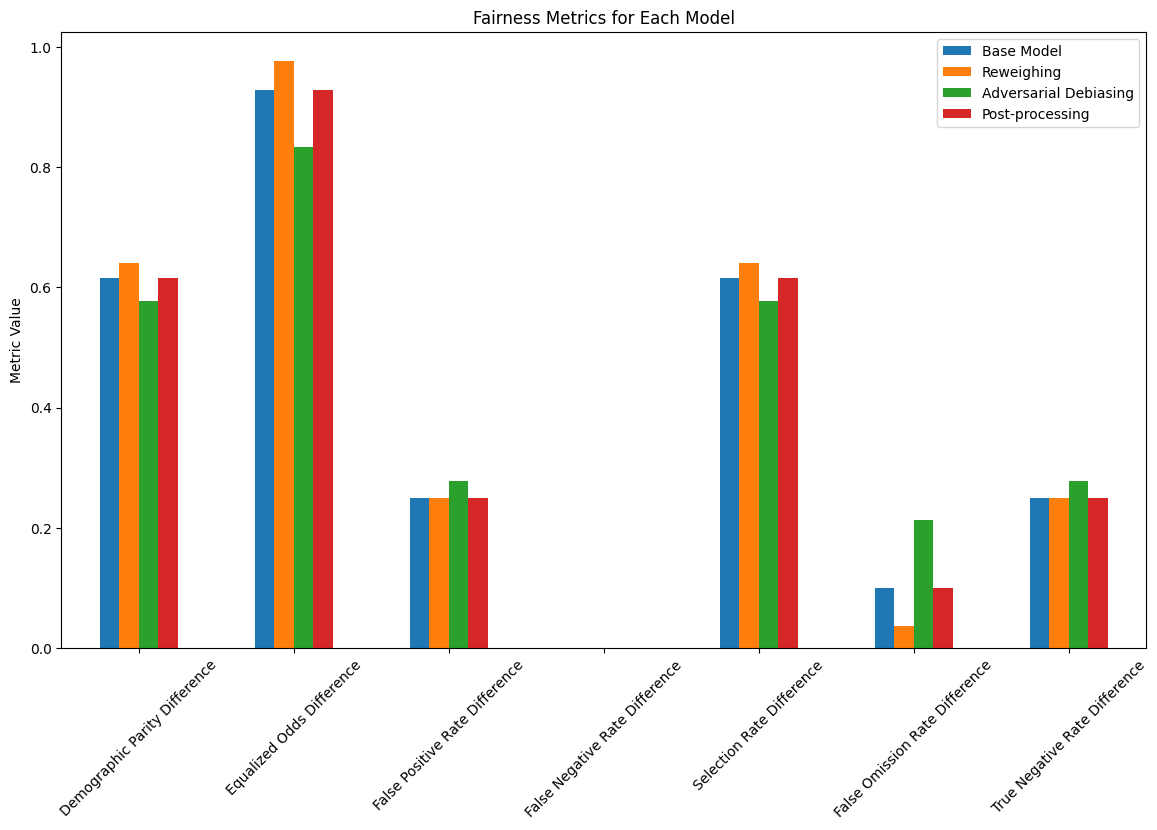

In [16]:
# Calculate fairness metrics for all models
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fprd = false_positive_rate_difference(y_true, y_pred, sensitive_features)
    fnrd = false_negative_rate_difference(y_true, y_pred, sensitive_features)
    srd = selection_rate_difference(y_pred, sensitive_features)
    for_diff = false_omission_rate_difference(y_true, y_pred, sensitive_features)
    tnr_diff = true_negative_rate_difference(y_true, y_pred, sensitive_features)
    
    return {
        'Demographic Parity Difference': dpd,
        'Equalized Odds Difference': eod,
        'False Positive Rate Difference': fprd,
        'False Negative Rate Difference': fnrd,
        'Selection Rate Difference': srd,
        'False Omission Rate Difference': for_diff,
        'True Negative Rate Difference': tnr_diff
    }

# Fairness metrics for each model
fairness_metrics_base = calculate_fairness_metrics(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'])
fairness_metrics_rw = calculate_fairness_metrics(y_test, y_pred_binary_rw, data.loc[X_test.index, 'age_bin'])
fairness_metrics_adv = calculate_fairness_metrics(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'])
fairness_metrics_pp = calculate_fairness_metrics(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])

# Create DataFrame for plotting
fairness_metrics_df = pd.DataFrame({
    'Base Model': fairness_metrics_base,
    'Reweighing': fairness_metrics_rw,
    'Adversarial Debiasing': fairness_metrics_adv,
    'Post-processing': fairness_metrics_pp
})

# Plot fairness metrics for each model
fairness_metrics_df.plot(kind='bar', figsize=(14, 8), title='Fairness Metrics for Each Model')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()


Demographic Parity Difference:

The Base Model, Reweighing Model, and Post-processing Model all show similar results around 0.62.
The Adversarial Debiasing Model has a slightly lower difference at 0.58, indicating a marginally better performance in terms of demographic parity.
Equalized Odds Difference:

The Reweighing Model shows the highest difference at 0.98, suggesting it performs the worst on this metric.
The Adversarial Debiasing Model performs the best with a difference of 0.83.
Both the Base Model and Post-processing Model have similar results around 0.93.
False Positive Rate Difference:

All models perform similarly with differences ranging from 0.25 to 0.28.
The Adversarial Debiasing Model shows a slightly higher difference (0.28) compared to the other models (0.25).
False Negative Rate Difference:

This metric is not available (NaN) for any of the models, indicating that it might not be applicable or there were no false negatives observed.
Selection Rate Difference:

Similar to the demographic parity, the Base Model, Reweighing Model, and Post-processing Model have similar results around 0.62.
The Adversarial Debiasing Model again shows a slightly better performance with a lower difference of 0.58.
False Omission Rate Difference:

The Adversarial Debiasing Model stands out with the highest difference at 0.21, indicating it might not perform well on this metric.
The Reweighing Model performs best with the lowest difference (0.036).
Both the Base Model and Post-processing Model show similar results at 0.10.
True Negative Rate Difference:

All models show comparable performance with differences ranging between 0.25 and 0.28.
The Base Model and Post-processing Model have identical results at 0.25, while the Adversarial Debiasing Model shows a slightly higher difference (0.28).

Takeaways
Adversarial Debiasing Model generally performs better on metrics like Demographic Parity Difference and Equalized Odds Difference but shows higher False Omission Rate Difference.
Reweighing Model shows significant improvement in some areas but has the highest Equalized Odds Difference, indicating it may still have biases in certain aspects.
Base Model and Post-processing Model perform similarly across most metrics, suggesting that post-processing does not significantly change fairness metrics compared to the base model.
False Negative Rate Difference is not applicable or was not observed in any of the models, which could be an area for further investigation to understand the underlying reasons.